# Rt Live Model

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-amza6o1w because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Fetch data and select the state's data

In [2]:
df = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today())#-pd.Timedelta(days=1))
dfunn = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False)#-pd.Timedelta(days=1))
dfsev = get_and_process_covidtracking_data_ilsev(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [3]:
region = "Israel"
model_data = df.loc[region]
model_sev = dfsev.loc[region]
model_sev_dash = dfunn.loc[region]
model_sev_dash['positive'] = model_sev_dash['severe']
model_unn = dfunn.loc[region]

## Create the model instance and sample

In [4]:
gmsev = GenerativeModel(region, model_sev, buffer_days = 20, delay=2+5, sigma=0.07)
gmsev.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 2033 seconds.


In [5]:
gmsevdash = GenerativeModel(region, model_sev_dash, buffer_days = 20, delay=2+5, sigma=0.07)
gmsevdash.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 2815 seconds.


In [6]:
gmunn = GenerativeModel(region, model_unn, delay=2, sigma=0.07)
gmunn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1822 seconds.


## Summarize Model Output

In [7]:
resultsev = summarize_inference_data(gmsev.inference_data)
resultunn = summarize_inference_data(gmunn.inference_data)
resultsevdash = summarize_inference_data(gmsevdash.inference_data)

In [8]:
resultunn.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-12,1.328098,1.320639,1.152289,1.481307,3010.576152,2055.153656,1296.0,1296,100000
2020-12-13,1.323197,1.319250,1.162962,1.485703,3187.665300,2165.802421,1729.0,1729,100000
2020-12-14,1.328058,1.321230,1.182375,1.491365,3374.216012,2284.105242,2315.0,2315,100000
2020-12-15,1.323243,1.317394,1.180293,1.505103,3569.731872,2410.558143,2891.0,2891,100000
2020-12-16,1.322324,1.315274,1.152435,1.477565,3776.725078,2545.613387,2852.0,2852,100000
2020-12-17,1.315630,1.305403,1.145330,1.471807,3995.451526,2689.629281,2846.0,2846,100000
2020-12-18,1.307401,1.299531,1.111549,1.443586,4224.991364,2842.833145,2792.0,2792,100000
2020-12-19,1.298723,1.292341,1.141883,1.467679,4464.104890,3005.536267,1887.0,1887,100000
2020-12-20,1.292731,1.286062,1.110760,1.430772,4710.815174,3178.122798,3093.0,3093,100000


In [9]:
resultsev.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-11,1.232646,1.229097,1.072161,1.372315,72.677935,46.137436,51.0,51,10000
2020-12-12,1.232010,1.226609,1.082640,1.354808,75.740418,47.977858,37.0,37,10000
2020-12-13,1.231082,1.226077,1.064097,1.354783,78.939454,49.935472,59.0,59,10000
2020-12-14,1.229658,1.222701,1.088192,1.387604,82.270533,52.011581,50.0,50,10000
2020-12-15,1.227551,1.226614,1.074583,1.362525,85.727190,54.206795,60.0,60,10000
2020-12-16,1.225735,1.225037,1.081709,1.365575,89.307377,56.519688,60.0,60,10000
2020-12-17,1.222335,1.221031,1.086681,1.366831,93.009194,58.946043,69.0,69,10000
2020-12-18,1.215768,1.205981,1.066254,1.350720,96.833895,61.481137,59.0,59,10000
2020-12-19,1.203421,1.195912,1.036204,1.314645,100.766482,64.122453,59.0,59,10000


In [10]:
resultsevdash.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-12-12,1.234133,1.227078,1.094043,1.359840,87.801309,54.765288,44.0,44.0,100000
2020-12-13,1.232643,1.223084,1.076438,1.355379,91.619004,57.013879,70.0,70.0,100000
2020-12-14,1.225855,1.221185,1.074297,1.363549,95.520768,59.401201,61.0,61.0,100000
2020-12-15,1.218149,1.211176,1.090653,1.371064,99.544290,61.927706,65.0,65.0,100000
2020-12-16,1.211996,1.203294,1.057040,1.341364,103.659654,64.592227,65.0,65.0,100000
2020-12-17,1.204106,1.199615,1.040817,1.324459,107.809534,67.394426,76.0,76.0,100000
2020-12-18,1.197439,1.190610,1.044660,1.330462,111.985754,70.334083,66.0,66.0,100000
2020-12-19,1.187169,1.183534,1.042129,1.326165,116.181745,73.413422,72.0,72.0,100000
2020-12-20,1.171867,1.165408,1.013399,1.288565,120.392916,76.636099,69.0,69.0,100000


## Plot Model Output

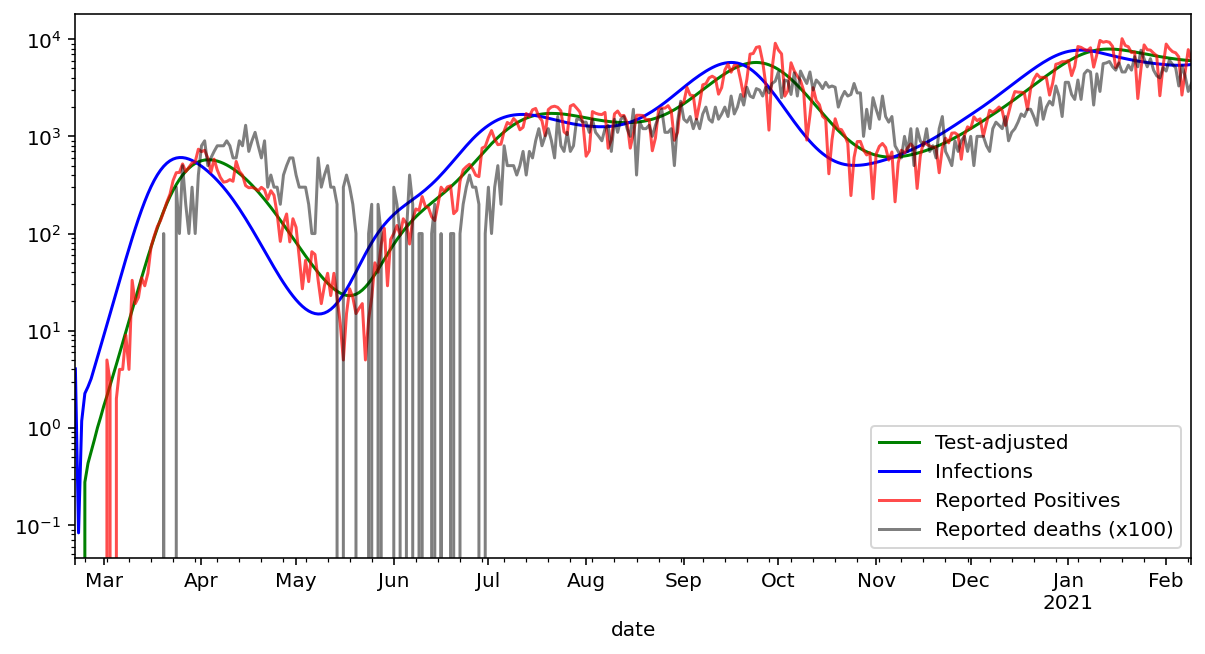

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
resultunn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultunn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultunn.infections.plot(c="b", label="Infections")
gmunn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
d = gmunn.observed.deaths * 100
d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

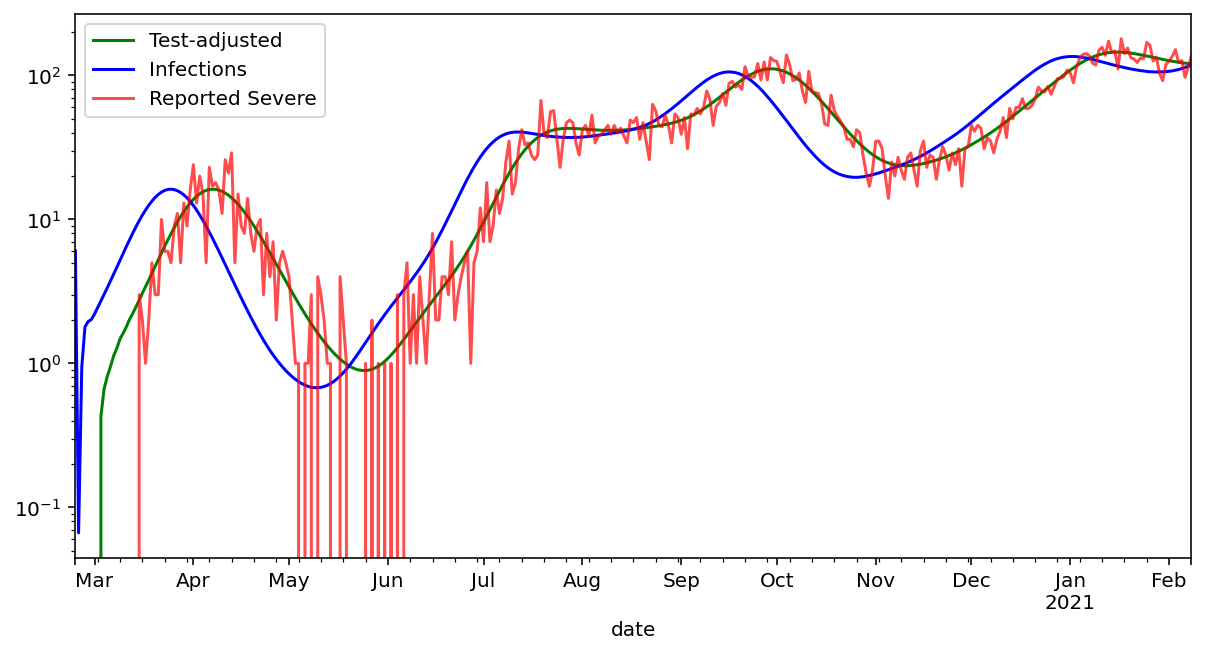

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
resultsev.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsev.infections.plot(c="b", label="Infections")
gmsev.observed.positive.plot(c='r', alpha=.7, label="Reported Severe")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

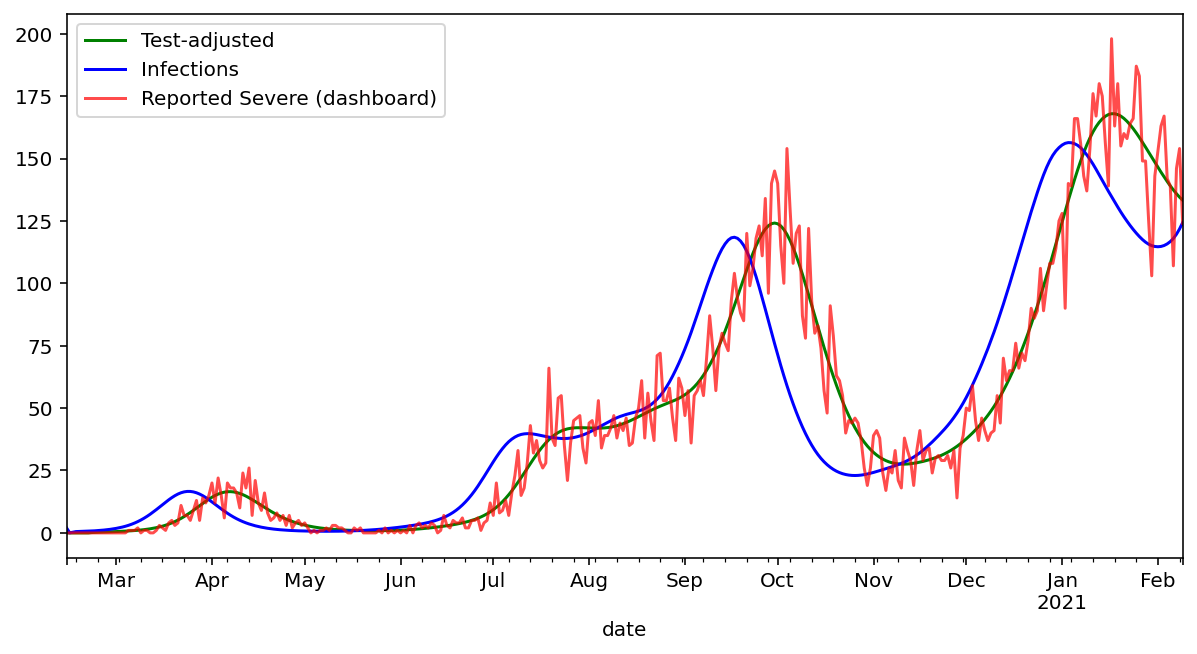

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
resultsevdash.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsevdash.infections.plot(c="b", label="Infections")
gmsevdash.observed.positive.plot(c='r', alpha=.7, label="Reported Severe (dashboard)")
fig.set_facecolor('w')
ax.legend();

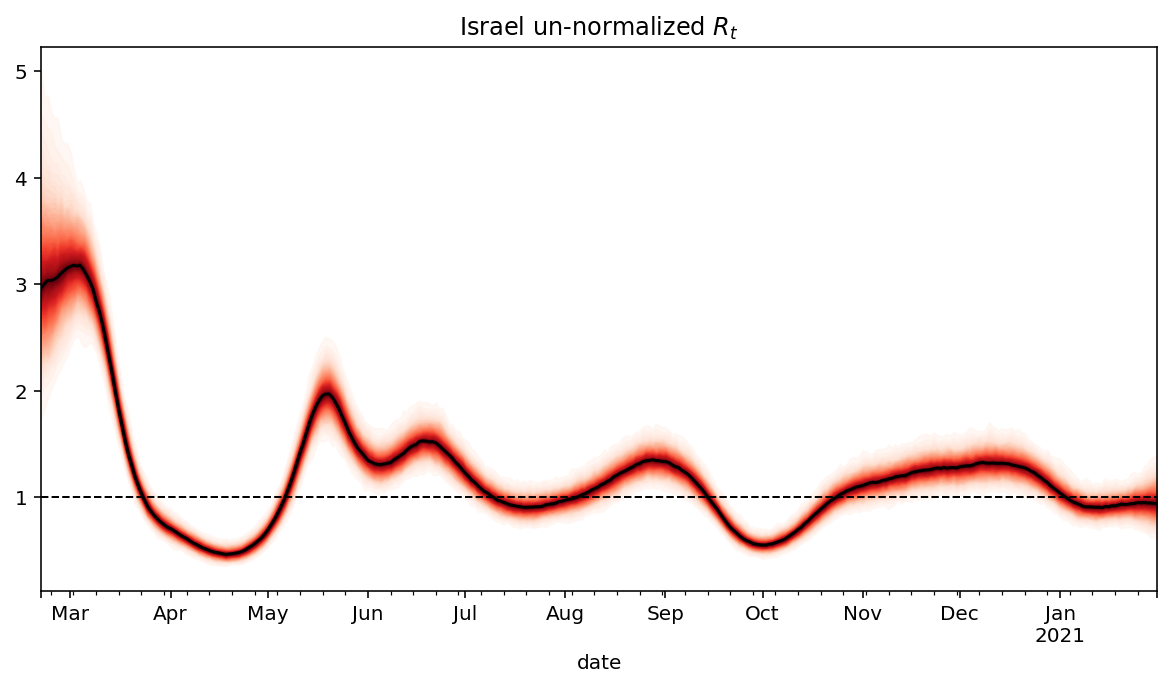

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=resultunn.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultunn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')
fig.savefig("Israel_unnorm_Rt_est.svg")

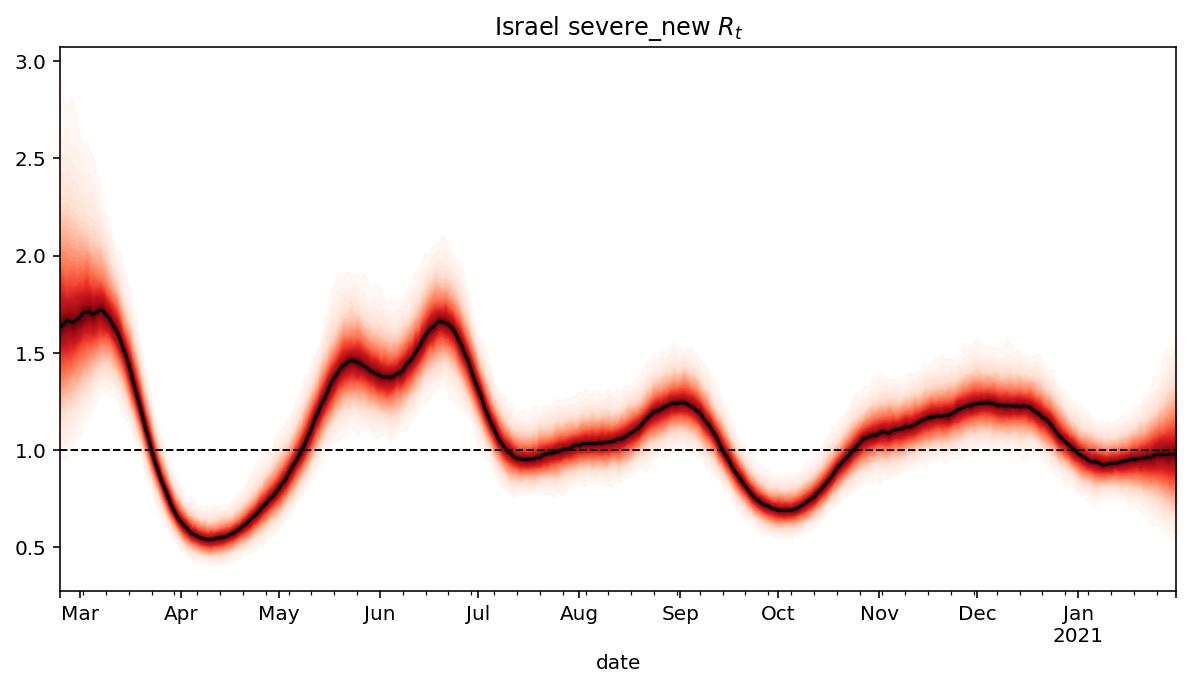

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new $R_t$")
samples = gmsev.trace['r_t']
x=resultsev.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsev["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

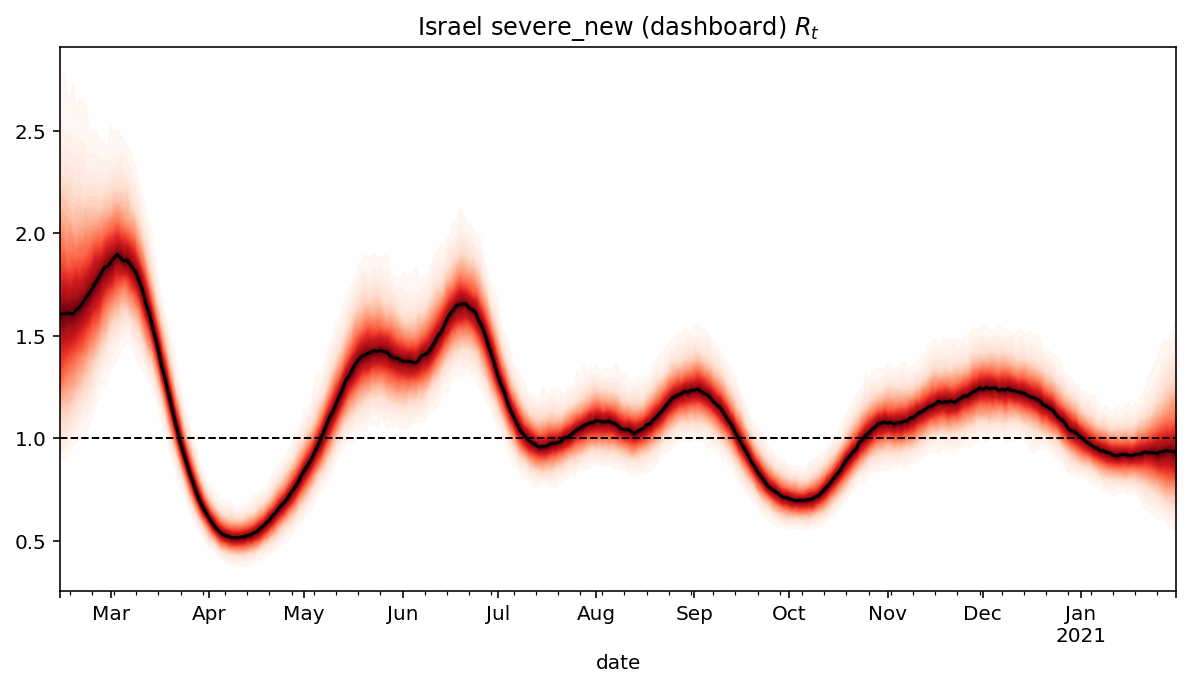

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new (dashboard) $R_t$")
samples = gmsevdash.trace['r_t']
x=resultsevdash.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsevdash["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

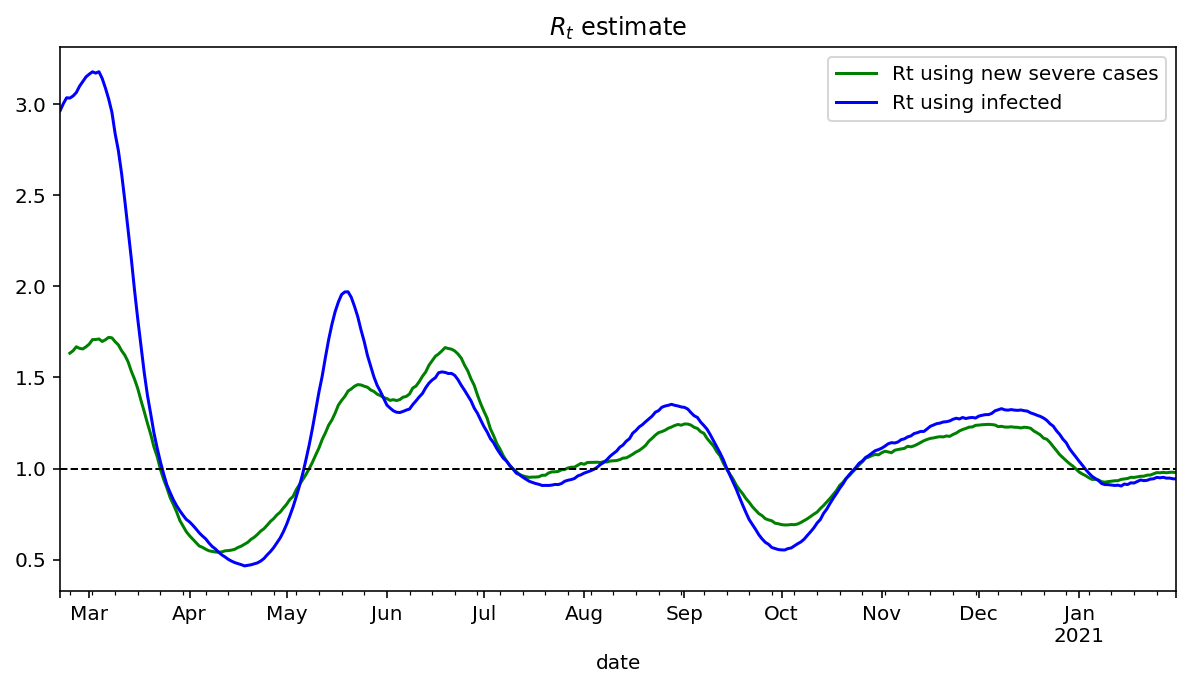

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"$R_t$ estimate")
resultsev["median"].plot(c="g", ls='-', label="Rt using new severe cases")
#resultsevdash["median"].plot(c="r", ls='-', label="Rt using new severe cases from dashboard")
resultunn["median"].plot(c="b", ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
ax.legend()

In [18]:
resultunn.to_csv("results_unnormalized_out.csv")

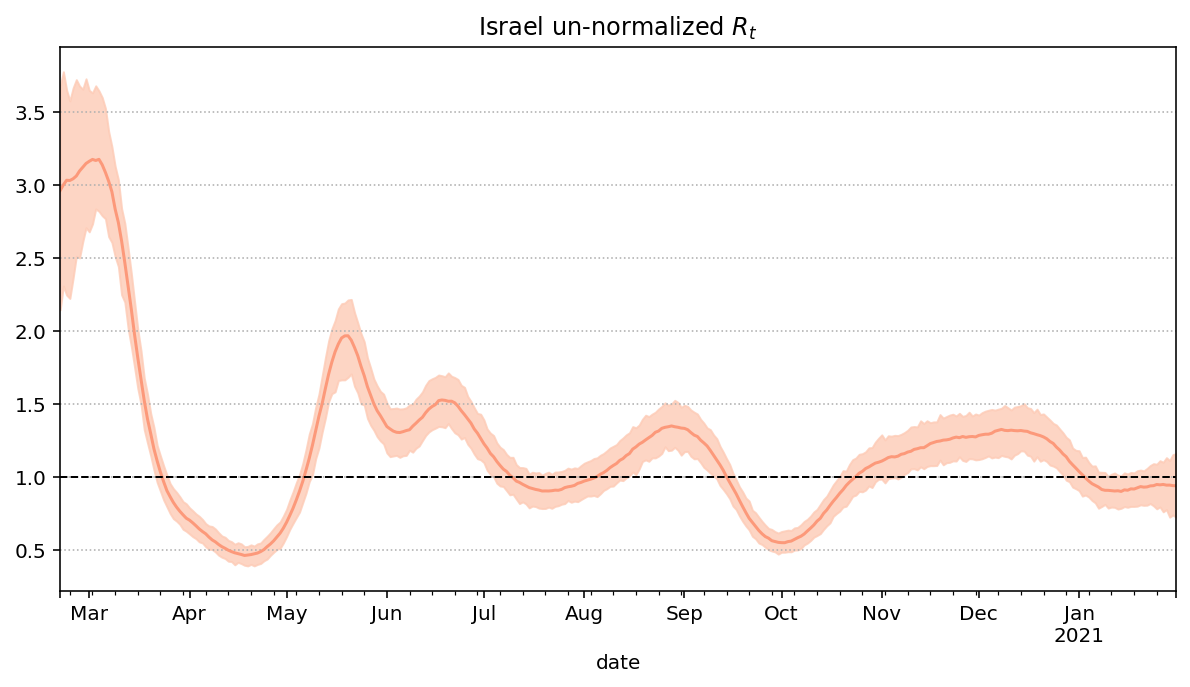

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=resultunn.index
cmap = plt.get_cmap("Reds")
ax.fill_between(x, resultunn["upper_80"], resultunn["lower_80"], color=cmap(50), alpha=.8)
resultunn["median"].plot(c=cmap(90), ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')
plt.grid(which='major', axis='y', ls=':')
fig.savefig("Israel_unnorm_Rt_est.svg")